In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ursse.phase_space_trajectory as pst
import ursse_cpp.sync_motion_sim as sm
from config_ursse import get_from_config, save_to_config
from ursse.path_assistant import PathAssistant
import os
images_dir = os.path.join(get_from_config("URSSE_sync_motion_note_dir"),
                          "images")

In [29]:
gamma = get_from_config("gamma")
alpha = get_from_config("ring_alpha")
V = get_from_config("Vrf")
f = 1/get_from_config("IOTA_revolution_period")
h = get_from_config("RF_q")
c = get_from_config("c_m/s")
rho= get_from_config("dipole_rho_m")
D = alpha*(1/f*c/2/np.pi)/rho

In [3]:
# save_to_config("damping_partition_JE", 2+D)

In [4]:
JE = get_from_config("damping_partition_JE")

In [35]:
hbar_c = 0.1973269804e-6
gamma_to_nav = 0.0661969
Ec = 3 / 2 * hbar_c * pow(gamma, 3) / rho
nav = gamma_to_nav*gamma
save_to_config("nav", nav)
save_to_config("Ec", Ec)

In [6]:
nav

12.48802575342958

# Textbook results for  rms bunch length

In [7]:
E0 = gamma*511000
v0 = V/E0
eta = alpha - 1/gamma**2
w = 2*np.pi*h*eta
delta_rms = 0.62e-6*gamma/np.sqrt(JE*rho)
print("delta rms = ", delta_rms)
tau_rms = 1e9*delta_rms/((f*h)*2*np.pi*np.sqrt(V/(2*np.pi*E0*h*np.abs(eta))))
print("tau_rms = ", tau_rms, "ns")

delta rms =  8.597426389751137e-05
tau_rms =  0.30651267688936373 ns


# Energy per turn distribution

Number of emitted photons is obtained from Poisson distribution, then the energy of each photon is obtained from InvSynchFractInt, then their sum is calculated


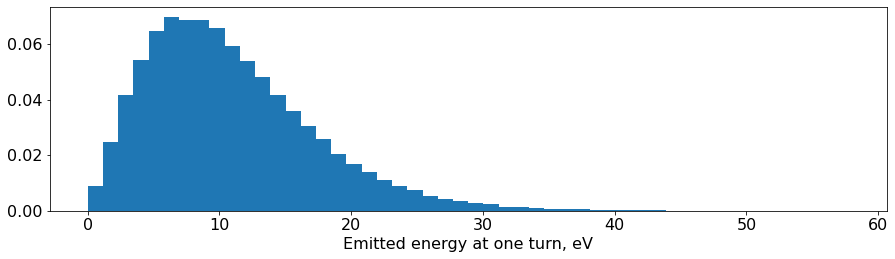

In [85]:
nrev = 100000
nphs = np.random.poisson(lam=nav, size=nrev)
ens = np.zeros(nrev)
for i,nph in enumerate(nphs):
    ens[i] = sum([sm.InvSynchFractInt(r) for r in np.random.rand(nph)])*Ec
plt.hist(ens, bins=50, density=True)
plt.xlabel("Emitted energy at one turn, eV")
print("Number of emitted photons is obtained from Poisson distribution,"
     " then the energy of each photon is obtained from InvSynchFractInt,"
     " then their sum is calculated")
plt.show()

In [86]:
Eav = np.mean(ens)
Eav

10.892379010187422

In [87]:
Estd = np.std(ens)
Estd

6.384864212778312

In [88]:
M = 1/(Estd/Eav)**2
M

2.910329477612393

In [89]:
k = M
theta = Eav/M
k, theta

(2.910329477612393, 3.7426618168068817)

In [91]:
save_to_config("M", M)

# Comparison of Gamma distribution with the simulated one

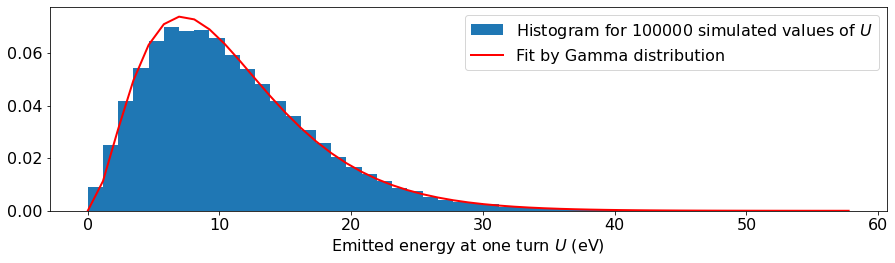

In [92]:
shape, scale = k, theta  # mean=4, std=2*sqrt(2)
nrolls = 100000
s = np.random.gamma(shape, scale, nrolls)
import scipy.special as sps 
fig, ax = plt.subplots()
count, bins, ignored = ax.hist(ens, bins=50, density=True,
        label=f'Histogram for {nrolls} simulated values of ' + r'$U$')
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
ax.plot(bins, y, linewidth=2, color='r', label='Fit by Gamma distribution')  
# plt.hist(sm.RandomEnergyGammaDistribution(k, theta, nrolls, 42),
#          bins=50, density=True,
#          label='From C++ - random variable with Gamma distribution')
ax.set_xlabel(r"Emitted energy at one turn $U$ (eV)")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
fig.savefig(os.path.join(images_dir,
                             "energy_per_turn_distribution.png"),
            dpi=300, bbox_inches='tight')
plt.show()

# Distribution for a single emitted photon

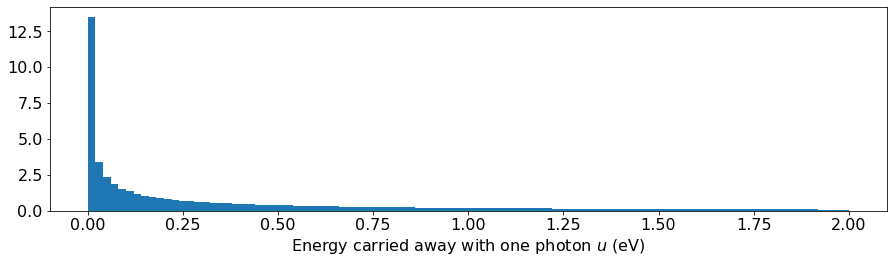

In [75]:
rands = np.random.rand(1000000)
en = np.zeros(shape=rands.shape)
Et = 8/9*np.pi*1/137*gamma*Ec
Scale = 15*np.sqrt(3)/8*Et
for i,r in enumerate(rands):
    en[i] = sm.InvSynchFractInt(r)*Ec
plt.hist(en, bins=100, range=(0,2.0),density=True)
plt.xlabel(r"Energy carried away with one photon $u$ (eV)")
plt.savefig(os.path.join(images_dir,
                             "one_photon_energy_density_function.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [82]:
Et

10.91643937761682

In [77]:
save_to_config("Et", Et)

In [78]:
phis = np.arcsin(Et/V)
save_to_config("phis", phis)

In [79]:
np.mean(en)

0.8748230560854254

In [80]:
np.std(en)

1.5883663417760907

# Simulation for 60 seconds

In [17]:
meas_df = pst.get_revolution_delay_df_one_gate(
    'shift_02_28_2020', '1el_002.ptu')

In [18]:
%%time
sim_df = sm.get_simulated_revolution_delay_data(
    gamma, alpha, V, f, h, JE, k, theta,
    meas_df['revolution'],
    tau0=0, delta0=0, rand_seed_int=3)

CPU times: user 1min 20s, sys: 110 ms, total: 1min 20s
Wall time: 1min 20s


In [19]:
print(f"Simulation rms bunch length = {sim_df.delay.std():.3f} ns")
print(f"Textbook equation rms bunch length = {tau_rms:.3f} ns")

Simulation rms bunch length = 0.308 ns
Textbook equation rms bunch length = 0.307 ns


# Comparison of simulation and measurement

In [20]:
sim_T0 = pst.get_initial_sync_period_estimate(sim_df)
sim_phase_df = pst.get_phase_df_from_revoluton_delay_df(sim_df, sim_T0)
sim_sz_df = pst.get_sz_df(sim_df, spad_tts_ns=0)
sim_polar_df = pst.get_polar_df(sim_phase_df, sim_sz_df)

In [21]:
meas_T0 = pst.get_initial_sync_period_estimate(meas_df)
spad_tts = 0.35
meas_phase_df = pst.get_phase_df_from_revoluton_delay_df(meas_df, meas_T0)
meas_sz_df = pst.get_sz_df(meas_df, spad_tts_ns=0)
meas_polar_df = pst.get_polar_df(meas_phase_df, meas_sz_df)

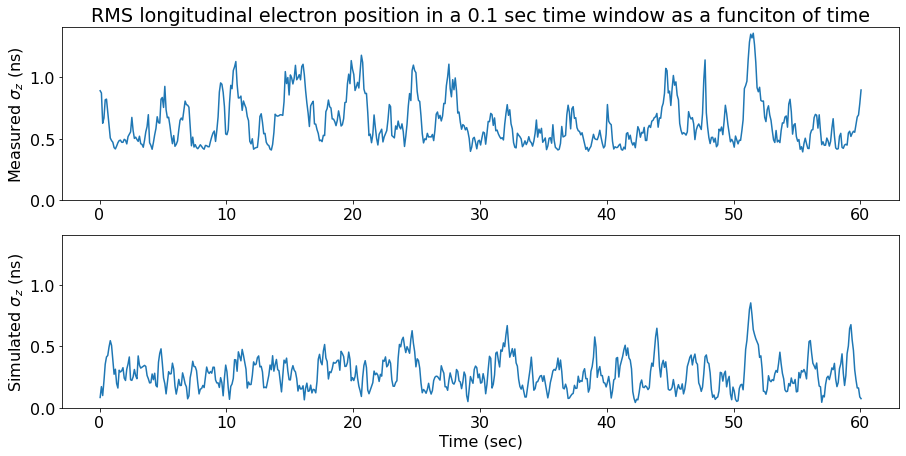

In [96]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].plot(meas_sz_df['time_sec'], meas_sz_df['sz_ns'])
ax[0].set_ylim(0,ax[0].get_ylim()[1])
ax[0].set_ylabel("Measured $\sigma_z$ (ns)")
ax[1].set_xlabel("Time (sec)")
ax[1].plot(sim_sz_df['time_sec'], sim_sz_df['sz_ns'])
ax[1].set_ylim(0,ax[1].get_ylim()[1])
ax[1].set_ylabel("Simulated $\sigma_z$ (ns)")
ax[1].set_ylim(ax[0].get_ylim())
ax[0].set_title("RMS longitudinal electron position in a 0.1 sec time window"
                " as a funciton of time")
fig.savefig(os.path.join(images_dir,
                             "comparison_of_rms_vs_time.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [23]:
np.sqrt(meas_df.delay.std()**2-spad_tts**2)

0.557154974838618

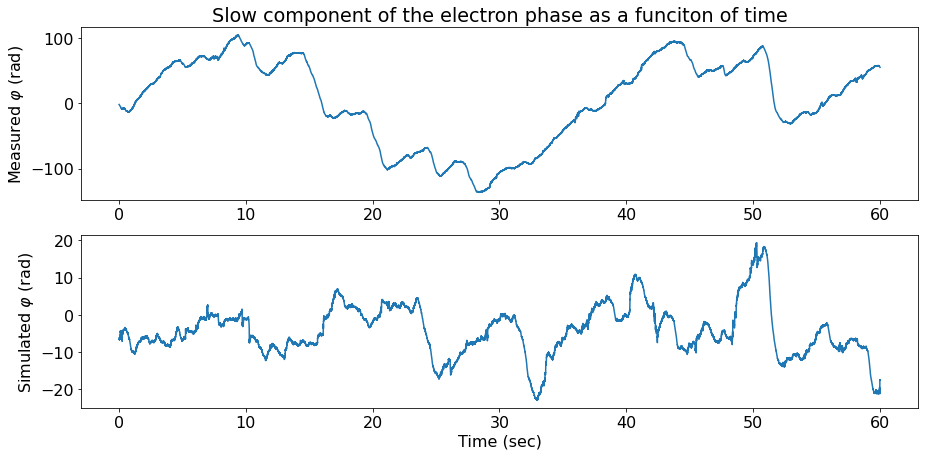

In [95]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].plot(meas_phase_df['time_sec'], meas_phase_df['phase_rad'])
ax[0].set_ylabel(r"Measured $\varphi$ (rad)")
ax[1].set_xlabel("Time (sec)")
ax[1].plot(sim_phase_df['time_sec'], sim_phase_df['phase_rad'])
ax[1].set_ylabel(r"Simulated $\varphi$ (rad)")
ax[0].set_title("Slow component of the electron phase as a funciton of time")
fig.savefig(os.path.join(images_dir,
                             "comparison_of_phase_vs_time.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [25]:
Eav*JE/E0

2.9968607951703386e-07

In [27]:
!pwd

/home/ilobach/ursse/analyzing_collected_data/shifts/shift_02_28_2020


In [26]:
meas_df.columns

Index(['revolution', 'delay', 'index_of_dt_bin', 'time_sec'], dtype='object')

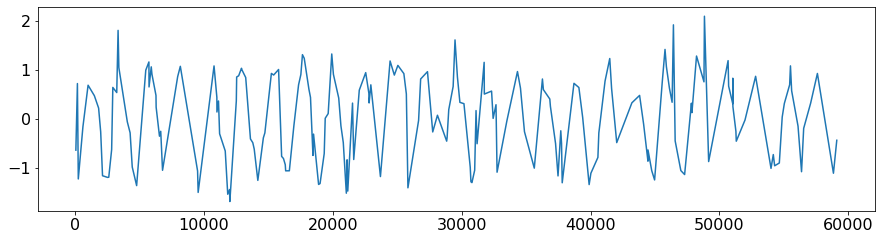

In [27]:
plot_df = meas_df.loc[:200,:]
plt.plot(plot_df.revolution, plot_df.delay)